# Classificação de Imagens usando Transfer Learning

Neste notebook vamos realizar a classificação de um conjunto de imagens utilizando a técnica de Transfer Learning.

In [ ]:
# Source: https://www.kaggle.com/paultimothymooney/breast-histopathology-images

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import BatchNormalization

import numpy as np
import pandas as pd


Primeiramente, vamos verificar se existe uma GPU em uso:

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)
tf.test.is_gpu_available() # True/False

2.8.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

A saída esperada é True! 

Agora vamos verificar qual GPU está alocada:

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr  8 19:11:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    35W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download Dataset

Vamos baixar o dataset "Fruits 360". Verifique mais informações [neste link](https://www.kaggle.com/moltean/fruits).

In [ ]:
!pip install -U gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=8d7f7e4ab940204ecd948060e786745f7225d2443822a56e508fe22f669ad8a4
  Stored in directory: /root/.cache/pip/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


In [ ]:
# https://drive.google.com/file/d/17V3cU7LEmG9ttDPRVwhHx-E5R37UxM2J/view?usp=sharing
!gdown --id  17V3cU7LEmG9ttDPRVwhHx-E5R37UxM2J

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17V3cU7LEmG9ttDPRVwhHx-E5R37UxM2J
To: /content/Fruits_360.zip
100% 1.38G/1.38G [00:14<00:00, 93.5MB/s]


In [ ]:
import os
import zipfile

local_zip = 'Fruits_360.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [ ]:
import os
classes = os.listdir('fruits-360_dataset/fruits-360/Training/')
len(classes)

131

Esse dataset possui 131 classes.

In [ ]:
test_dir=r'./fruits-360_dataset/fruits-360/Test'
train_dir=r'./fruits-360_dataset/fruits-360/Training'
datasets=[test_dir, train_dir]
for i, datadir in enumerate(datasets):
    filepaths=[]
    labels=[]
    classlist=os.listdir(datadir)
    for klass in classlist:
        classpath=os.path.join(datadir,klass)    
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
    Fseries= pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    if i == 0:
        test_df=pd.concat([Fseries, Lseries], axis=1)
    else:
        df=pd.concat([Fseries, Lseries], axis=1)         
print (df.head())
balance=df['labels'].value_counts()
blist=list(balance)
print (blist)

                                           filepaths     labels
0  ./fruits-360_dataset/fruits-360/Training/Manda...  Mandarine
1  ./fruits-360_dataset/fruits-360/Training/Manda...  Mandarine
2  ./fruits-360_dataset/fruits-360/Training/Manda...  Mandarine
3  ./fruits-360_dataset/fruits-360/Training/Manda...  Mandarine
4  ./fruits-360_dataset/fruits-360/Training/Manda...  Mandarine
[984, 900, 738, 738, 738, 738, 738, 738, 738, 735, 711, 702, 702, 702, 702, 696, 684, 672, 672, 666, 666, 666, 654, 534, 493, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 491, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 481, 480, 480, 479, 479, 475, 474, 471, 471, 468, 468, 466, 464, 462, 462, 459, 456, 453, 450, 450, 450, 450, 450, 450, 450, 450, 450, 447, 445, 444, 444, 438, 429, 

In [ ]:
print ('original number of classes: ', len(df['labels'].unique()))     
size=297 # set number of samples for each class
samples=[]
group=df.groupby(labels)
for label in df['labels'].unique():
    Lgroup=group.get_group(label)
    count=int(Lgroup['labels'].value_counts())    
    if count>=size:
        sample=Lgroup.sample(size, axis=0)
        samples.append(sample) 
df=pd.concat(samples, axis=0).reset_index(drop=True)
print (len(df))
print ('final number of classes: ', len(df['labels'].unique()))       
print (df['labels'].value_counts())  

original number of classes:  131
38907
final number of classes:  131
Mandarine              297
Apple Granny Smith     297
Apple Red Delicious    297
Physalis with Husk     297
Pear Monster           297
                      ... 
Chestnut               297
Cactus fruit           297
Cucumber Ripe          297
Grapefruit Pink        297
Cherry 2               297
Name: labels, Length: 131, dtype: int64


In [ ]:
train_df

,filepaths,labels
7514,./fruits-360_dataset/fruits-360/Training/Grape...,Grape Pink
21057,./fruits-360_dataset/fruits-360/Training/Apple...,Apple Red 2
34183,./fruits-360_dataset/fruits-360/Training/Pepin...,Pepino
33855,./fruits-360_dataset/fruits-360/Training/Apple...,Apple Braeburn
27862,./fruits-360_dataset/fruits-360/Training/Apple...,Apple Red Yellow 1
...,...,...
7763,./fruits-360_dataset/fruits-360/Training/Kaki/...,Kaki
15377,./fruits-360_dataset/fruits-360/Training/Apple...,Apple Golden 2
17730,./fruits-360_dataset/fruits-360/Training/Tamar...,Tamarillo
28030,./fruits-360_dataset/fruits-360/Training/Pear ...,Pear Monster


In [ ]:
from sklearn.model_selection import train_test_split
train_split=.9
train_df, valid_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))



train_df length:  35016   test_df length:  22688   valid_df length:  3891


# Generators

Vamos criar os generators, que são responsáveis por carregar as imagens na memória e realizar quaisquer transformações necessárias. Neste dataset, as imagens está armazenada em um arquivo .csv. Verifique a documentação oficial [neste link](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

Fonte: https://www.kaggle.com/gpiosenka/inceptionresnet-using-reduced-size-dataset

In [ ]:
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1

In [ ]:
height=100
width=100
channels=3
batch_size=128
test_batch_size=10
img_shape=(height, width, channels)
img_size=(height, width)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen=ImageDataGenerator(preprocessing_function=scalar)    

train_generator = gen.flow_from_dataframe(
    train_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical', 
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size)


test_generator = gen.flow_from_dataframe(
    test_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=test_batch_size)

val_generator = gen.flow_from_dataframe(
    valid_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size)      

Found 35016 validated image filenames belonging to 131 classes.
Found 22688 validated image filenames belonging to 131 classes.
Found 3891 validated image filenames belonging to 131 classes.


# Ploting Images

Vamos ver alguns exemplos das imagens.

In [ ]:
import matplotlib.pyplot as plt
def show_image_samples(gen ):
    test_dict=test_generator.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()


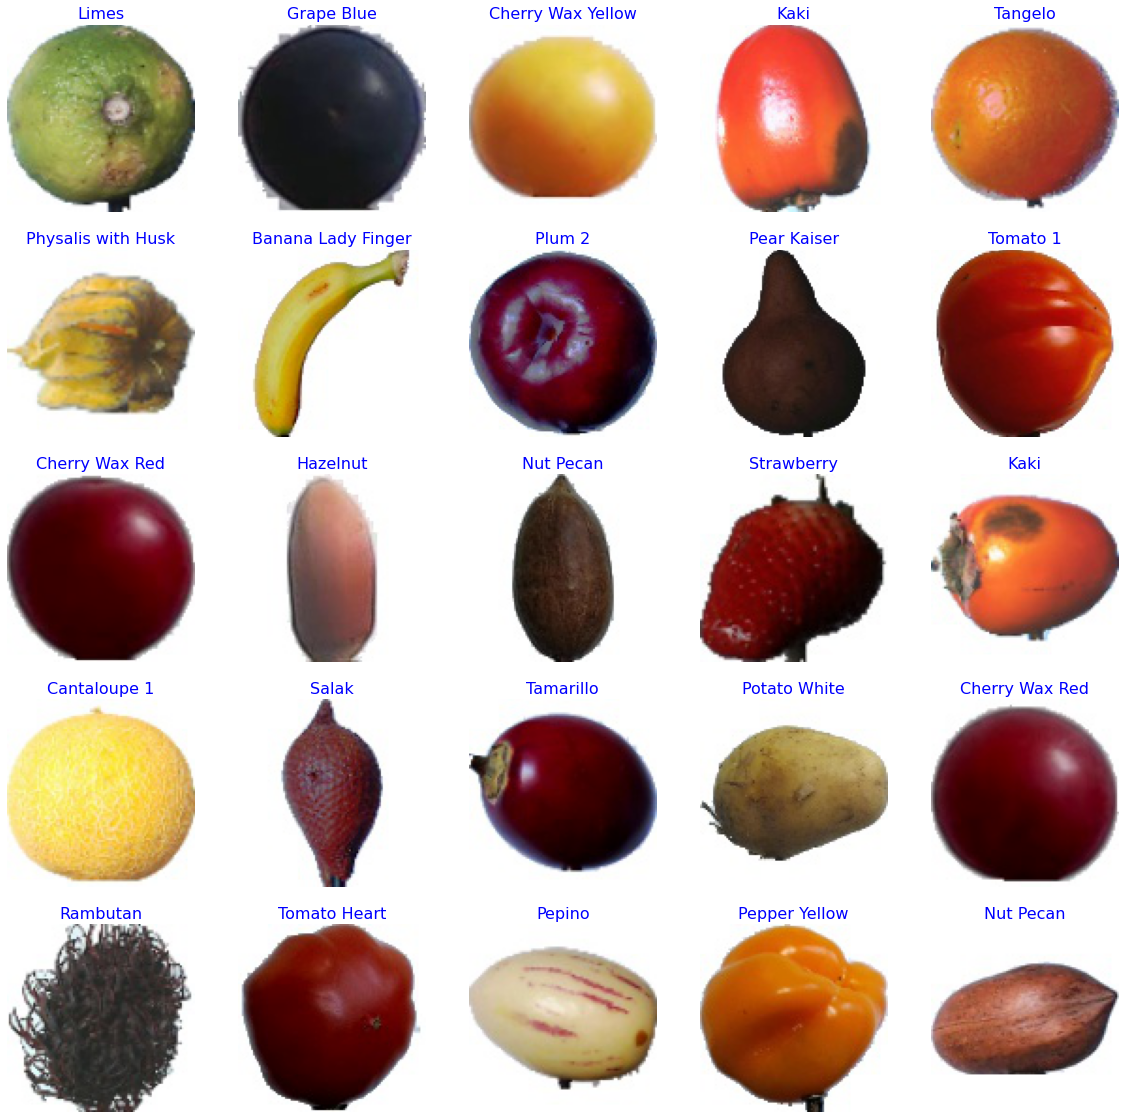

In [ ]:
show_image_samples(train_generator)



# Download InceptionV3 Model

Vamos baixar o modelo InceptionV3 treinado no dataset ImageNet. Outros modelos podem ser observados [neste link](https://keras.io/api/applications/).

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3

inception_model=tf.keras.applications.inception_v3.InceptionV3(
    include_top=False, 
    weights="imagenet",
    input_shape=img_shape, 
    pooling='max'
) 

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 49, 49, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

# Método de Transfer Learning

Vamos utilizar o método de transfer learning para adaptar o modelo baixado para nossa tarefa de classificação.

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

x = inception_model.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x = Dropout(rate=.45, seed=123)(x)        
output = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=inception_model.input, outputs=output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 49, 49, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
from tensorflow.keras.optimizers import Adam 
opt = Adam(learning_rate=0.01)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Training

Agora, vamos iniciar o treinamento do nosso modelo. Lembre-se que, da forma como configuramos as camadas, apenas a última camada será treinada.

In [ ]:
#Defining the parameters
epochs=30

In [ ]:
history = model.fit(train_generator, validation_data=val_generator, epochs = epochs)

Epoch 1/30
274/274 [==============================] - 56s 138ms/step - loss: 6.5968 - accuracy: 0.0122 - val_loss: 5.2708 - val_accuracy: 0.0129
Epoch 2/30
274/274 [==============================] - 35s 129ms/step - loss: 4.2922 - accuracy: 0.0866 - val_loss: 16.1406 - val_accuracy: 0.0072
Epoch 3/30
274/274 [==============================] - 35s 129ms/step - loss: 2.9675 - accuracy: 0.2499 - val_loss: 6.6407 - val_accuracy: 0.2077
Epoch 4/30
274/274 [==============================] - 35s 129ms/step - loss: 2.3757 - accuracy: 0.3995 - val_loss: 14.5987 - val_accuracy: 0.0735
Epoch 5/30
274/274 [==============================] - 35s 129ms/step - loss: 2.0987 - accuracy: 0.4917 - val_loss: 2.3711 - val_accuracy: 0.4151
Epoch 6/30
274/274 [==============================] - 35s 129ms/step - loss: 1.8150 - accuracy: 0.5837 - val_loss: 3.9567 - val_accuracy: 0.2467
Epoch 7/30
274/274 [==============================] - 35s 129ms/step - loss: 1.4850 - accuracy: 0.6843 - val_loss: 2.1169 - val_

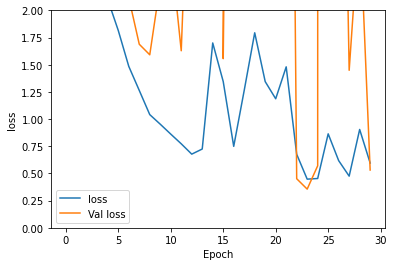

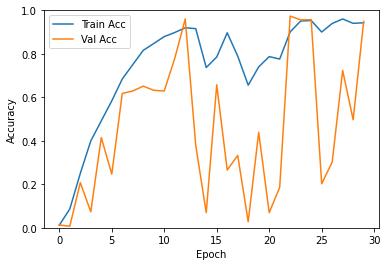

In [ ]:
from matplotlib import pyplot as plt
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='loss')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val loss')
    plt.ylim([0,2])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Acc')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Acc')
    plt.ylim([0,1])
    plt.legend()
    plt.show()


plot_history(history)


# Salvando o Modelo

Você pode salvar um modelo inteiro em um único. Para isso, execute o comando a seguir. Para mais informações, verifique [https://www.tensorflow.org/guide/keras/save_and_serialize](https://www.tensorflow.org/guide/keras/save_and_serialize)

In [ ]:
model.save('save_model/inception_v3_fruits_model.h5')


Para baixar o modelo para seu computador, execute o próximo comando.

In [ ]:
from google.colab import files
files.download('save_model/inception_v3_fruits_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Salvar e baixar todo o modelo pode demorar um pouco. Talvez a melhor opção seja salvar apenas os pesos.

In [ ]:
model.save_weights("save_model/inception_v3_fruits-ckpt")


In [ ]:
!ls -lha save_model/

total 256M
drwxr-xr-x 2 root root 4.0K Sep 17 15:18 .
drwxr-xr-x 1 root root 4.0K Sep 17 15:18 ..
-rw-r--r-- 1 root root  105 Sep 17 15:18 checkpoint
-rw-r--r-- 1 root root 256M Sep 17 15:18 inception_v3_fruits-ckpt.data-00000-of-00001
-rw-r--r-- 1 root root  54K Sep 17 15:18 inception_v3_fruits-ckpt.index


In [ ]:
!tar -jcvf save_model_inception_v3_fruits.tar.bz save_model/

save_model/
save_model/inception_v3_fruits-ckpt.index
save_model/inception_v3_fruits-ckpt.data-00000-of-00001
save_model/checkpoint


In [ ]:
from google.colab import files
files.download('save_model_inception_v3_fruits.tar.bz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Carregando o Modelo

In [ ]:
load_status = model.load_weights("save_model/inception_v3_fruits-ckpt")
load_status

In [ ]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("save_model/inception_v3_fruits_model.h5")


# Testing

In [ ]:
scores = model.evaluate(test_generator)
print("Accuracy: {}".format(scores[1]))


2269/2269 [==============================] - 48s 21ms/step - loss: 1.8192 - accuracy: 0.6643
Accuracy: 0.664271891117096
